# Wide and Deep Recommender System - Expedia Hotel dataset

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import tensorflow as tf
import warnings
import math
from math import sqrt

import sys
import holidays

from sklearn.metrics import roc_curve, auc,roc_auc_score
from sklearn import metrics
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from deepctr.inputs import build_input_features, get_linear_logit, input_from_feature_columns, combined_dnn_input
from deepctr.layers.core import PredictionLayer, DNN
from deepctr.layers.utils import add_func
from deepctr.models import WDL
from deepctr.inputs import SparseFeat,get_feature_names
import datetime

/Users/yas/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [7]:
df = pd.read_csv('../data/hotel_data/train.csv', sep=',', nrows=150000)
destinations = pd.read_csv('../data/hotel_data/destinations.csv', sep=',')
df.shape

(150000, 24)

In [8]:
#merge only top 10 most correlated columns with rating column
df = pd.merge(df,destinations[['srch_destination_id','d33', 'd64', 'd52', 'd120', 'd72', 'd136', 'd7', 'd59', 'd50', 'd30']],on='srch_destination_id')

In [9]:
# rename 2 columns
df = df.rename(columns={'hotel_cluster': 'item_id', 'is_booking': 'rating'})

In [10]:
df = df.dropna()

In [11]:
df.shape

(96910, 34)

## Feature Engineering

## date_time

### Extract week and month

In [12]:
# sort values
from pandas.tseries.offsets import Week
df = df.sort_values("date_time").reset_index()
df.drop('index',axis=1,inplace=True)

In [13]:
df["date_time"] =  pd.to_datetime(df["date_time"], infer_datetime_format=True)
df["date_time"] = df.date_time.dt.strftime('%Y-%m-%d')
#df["date_time_timestamp"] =  pd.to_datetime(df["date_time"], infer_datetime_format=True)

In [14]:
d = datetime.timedelta(days=14)
df['lagged_date_time'] = df["date_time"].apply(lambda x: datetime.datetime.strptime(x,"%Y-%m-%d") + d)

#df["str_lagged_date_time"] = df.lagged_date_time.dt.strftime('%Y-%m-%d')
#df["lagged_date_time"][1].strftime("%B")
#df["date_time_timestamp"].apply(lambda x: x.strftime("%Y-%U-%w"))

In [15]:
#df['num_visit']=1
#df_test = df.groupby([pd.Grouper(key='lagged_date_time', freq='W-MON')])['num_visit'].count().reset_index().set_index('lagged_date_time').sort_values('lagged_date_time')

In [16]:
#df['expand_sum']=df['num_visit'].expanding().sum()
#df['roll_mean_3']=df['num_visit'].rolling(5).sum()

In [17]:
def extract_week(feature,week,lag):
    df[feature] =  pd.to_datetime(df[feature], infer_datetime_format=True)
    df[feature] = df.date_time.dt.strftime('%Y-%m-%d')
    if lag == True:
        d = datetime.timedelta(days=14)
        df['lag_date_time'] = df[feature].apply(lambda x: datetime.datetime.strptime(x,"%Y-%m-%d") + d)
        df['week'] = pd.DatetimeIndex(df['lag_date_time']).week
        df['year']=pd.DatetimeIndex(df['lag_date_time']).year
        
        # countinue week numbers for the next year
        df[week] = df['week'].where(df['year'] ==2013 , df['week']+52)

In [18]:
extract_week('date_time','click_week',lag=True)

In [19]:
df.head()

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,d136,d7,d59,d50,d30,lagged_date_time,lag_date_time,week,year,click_week
0,2013-01-07,2,3,66,331,2428,477.1799,191940,0,0,...,-2.185435,-2.185435,-2.185435,-2.185435,-2.185435,2013-01-21,2013-01-21,4,2013,4
1,2013-01-07,2,3,66,174,46432,2738.4972,144246,0,1,...,-2.286141,-2.293998,-2.293998,-2.293998,-2.293998,2013-01-21,2013-01-21,4,2013,4
2,2013-01-07,2,3,66,331,2428,477.1799,191940,0,0,...,-2.185435,-2.185435,-2.185435,-2.185435,-2.185435,2013-01-21,2013-01-21,4,2013,4
3,2013-01-07,2,3,66,174,46432,2387.7275,144246,0,1,...,-2.325230,-2.342028,-2.342028,-2.342028,-2.306268,2013-01-21,2013-01-21,4,2013,4
4,2013-01-07,2,3,66,174,46432,2384.9256,144246,0,1,...,-2.301329,-2.348166,-2.348217,-2.345951,-2.343426,2013-01-21,2013-01-21,4,2013,4


In [20]:
# extract month from date_time
df['click_month'] = pd.DatetimeIndex(df['date_time']).month

## checkin_month , checkout_month

In [21]:
df['checkin_month'] = pd.DatetimeIndex(df['srch_ci']).month
df['checkout_month'] = pd.DatetimeIndex(df['srch_co']).month

df['checkin_year'] = pd.DatetimeIndex(df['srch_ci']).year
df['checkout_year'] = pd.DatetimeIndex(df['srch_co']).year

## add holiday

In [22]:
# Define holidays in some countries
ca_holidays = holidays.Canada()
us_holidays = holidays.UnitedStates()

In [23]:
# check if checkin or checkout date is in holiday of different countries

df['north_am_ci'] = df['srch_ci'].apply(lambda x: 1 if x in (us_holidays or ca_holidays)  else 0)
df['north_am_co'] = df['srch_co'].apply(lambda x: 1 if x in (us_holidays or ca_holidays)  else 0)

In [24]:
df= df.drop(['date_time'],axis=1)
df= df.drop(['week'],axis=1)
df= df.drop(['year'],axis=1)
df= df.drop(['srch_ci'],axis=1)
df= df.drop(['srch_co'],axis=1)
df= df.drop(['lag_date_time'],axis=1)
#df= df.drop(['date_time_timestamp'],axis=1)
df= df.drop(['lagged_date_time'],axis=1)
#df= df.drop(['num_visit'],axis=1)

In [25]:
df.columns

Index(['site_name', 'posa_continent', 'user_location_country',
       'user_location_region', 'user_location_city',
       'orig_destination_distance', 'user_id', 'is_mobile', 'is_package',
       'channel', 'srch_adults_cnt', 'srch_children_cnt', 'srch_rm_cnt',
       'srch_destination_id', 'srch_destination_type_id', 'rating', 'cnt',
       'hotel_continent', 'hotel_country', 'hotel_market', 'item_id', 'd33',
       'd64', 'd52', 'd120', 'd72', 'd136', 'd7', 'd59', 'd50', 'd30',
       'click_week', 'click_month', 'checkin_month', 'checkout_month',
       'checkin_year', 'checkout_year', 'north_am_ci', 'north_am_co'],
      dtype='object')

In [26]:
#Note that we add 1 to the raw count to prevent the logarithm from
# exploding into negative infinity in case the count is zero.
df['log_orig_destination_distance'] = np.log10(df['orig_destination_distance'] + 1)

In [27]:
df= df.drop(['orig_destination_distance'],axis=1)

In [28]:
from sklearn.cluster import KMeans
def create_cluster(feature):
    y = df[feature]
    X = df.drop(feature,axis=1)
    wcss=[]
    for i in range(1,11):
        kmeans = KMeans(n_clusters= i, init='k-means++', random_state=0)
        kmeans.fit(X)
        wcss.append(kmeans.inertia_)
    plt.plot(range(1,11), wcss)
    plt.title('The Elbow Method')
    plt.xlabel('number of clusters')
    plt.ylabel('wcss')
    plt.show()

In [29]:
X = df.drop("user_location_region",axis=1)
kmeansmodel = KMeans(n_clusters= 3, init='k-means++', random_state=0)
y_kmeans= kmeansmodel.fit_predict(X)
df['kmeans_user_location_region']=y_kmeans
df= df.drop(['user_location_region'],axis=1)

In [30]:
X = df.drop("user_location_city",axis=1)
kmeansmodel = KMeans(n_clusters= 3, init='k-means++', random_state=0)
y_kmeans= kmeansmodel.fit_predict(X)
df['kmeans_user_location_city']=y_kmeans
df= df.drop(['user_location_city'],axis=1)

In [31]:
condlist = [(df['srch_adults_cnt']==0) & (df['srch_children_cnt']==0),
            (df['srch_adults_cnt']==2) & (df['srch_children_cnt']==0),
            (df['srch_adults_cnt']==2) & (df['srch_children_cnt']==1),
            (df['srch_adults_cnt']==2) & (df['srch_children_cnt']==2),
           (df['srch_adults_cnt']==1) & (df['srch_children_cnt']==0),
            (df['srch_adults_cnt']>1) & (df['srch_children_cnt']>0),
           (df['srch_adults_cnt']==1) & (df['srch_children_cnt'] > 0),
           (df['srch_adults_cnt']>2) & (df['srch_children_cnt'] == 0),
           (df['srch_adults_cnt']==0) & (df['srch_children_cnt'] > 0)]

choicelist = ['empty_room',
                'couple_with_no_children',
                'couple_with_one_child',
                'couple_with_two_children',
                'single',
                'big_family',
                'single_parent',
                'friends',
                'unsupervised_children']

df['family_status'] = np.select(condlist,choicelist)

In [32]:
#Convert the family_status into dummy variables
dummies = pd.get_dummies(df['family_status'],drop_first=True)
df= pd.concat( [df.drop('family_status',axis=1),dummies],axis=1)

In [33]:
if "unsupervised_children" in df.columns:
    df= df.drop("unsupervised_children",axis=1)
if "empty_room" in df.columns:
    df= df.drop("empty_room",axis=1)

## z-score normalizing

In [29]:
df['cnt'] = (df['cnt'] - df['cnt'].mean())/df['cnt'].std()

In [30]:
df.shape

(8649, 45)

In [31]:
df.columns

Index(['site_name', 'posa_continent', 'user_location_country', 'user_id',
       'is_mobile', 'is_package', 'channel', 'srch_adults_cnt',
       'srch_children_cnt', 'srch_rm_cnt', 'srch_destination_id',
       'srch_destination_type_id', 'rating', 'cnt', 'hotel_continent',
       'hotel_country', 'hotel_market', 'item_id', 'd33', 'd64', 'd52', 'd120',
       'd72', 'd136', 'd7', 'd59', 'd50', 'd30', 'click_week', 'click_month',
       'checkin_month', 'checkout_month', 'checkin_year', 'checkout_year',
       'north_am_ci', 'north_am_co', 'log_orig_destination_distance',
       'kmeans_user_location_region', 'kmeans_user_location_city',
       'couple_with_no_children', 'couple_with_one_child',
       'couple_with_two_children', 'friends', 'single', 'single_parent'],
      dtype='object')

In [34]:
# categ_sparse / conti_dense
sparse_features = ["site_name", #ID of the Expedia point of sale (i.e. Expedia.com, Expedia.co.uk, Expedia.co.jp, …)
"posa_continent", #ID of continent associated with site_name
"user_location_country", #The ID of the country the customer is located
"kmeans_user_location_region", #The ID of the region the customer is located clustered in 2 groups
"kmeans_user_location_city", #The ID of the city the customer is located clustered in 2 groups
"user_id", #ID of user
"is_mobile", #1 when a user connected from a mobile device, 0 otherwise
"is_package", #1 if the click/booking was generated as a part of a package (i.e. combined with a flight), 0 otherwise
"channel", #ID of a marketing channel
"cnt", #Numer of similar events in the context of the same user session
"srch_destination_id", #ID of the destination where the hotel search was performed'
"srch_destination_type_id", #Type of destination
"hotel_continent", #'Hotel continent',
"hotel_country", #Hotel country
"item_id", #(hotel_cluster)ID of a hotel cluster
"north_am_ci", # 1 if check-in date it's a holiday in north America
"north_am_co",# 1 if check-out date it's a holiday in north America
'hotel_market', #Hotel market
'couple_with_no_children','couple_with_one_child','couple_with_two_children',"friends","single","single_parent",
#hotel search latent attributes highly correlated with rating:
'd33', 'd64','d52','d120', 'd72', 'd136', 'd7', 'd59', 'd50', 'd30'] 

dense_features = ["srch_adults_cnt", #The number of adults specified in the hotel room
"srch_children_cnt", #The number of (extra occupancy) children specified in the hotel room
"srch_rm_cnt", #The number of hotel rooms specified in the search
'log_orig_destination_distance', # Log transformed physical distance between a hotel and a customer at the time of search
"click_week",
"click_month",
"checkin_month",
"checkout_month",
"checkin_year",
"checkout_year"]
target = ['rating']

### Simple preprocessing

In [35]:
# Label Encoding for sparse features,and normalization for dense numerical features
for feat in sparse_features:
    lbe = LabelEncoder()
    df[feat] = lbe.fit_transform(df[feat])

In [36]:
mms = MinMaxScaler(feature_range=(0,1))
df[dense_features] = mms.fit_transform(df[dense_features])

### Generate feature columns
For sparse features, we transform them into dense vectors by embedding techniques. For dense numerical features, we concatenate them to the input tensors of fully connected layer.

In [37]:
# count #unique features for each sparse field
fixlen_feature_columns = [SparseFeat(feat, df[feat].nunique(),embedding_dim=4)
                          for feat in sparse_features]
linear_feature_columns = fixlen_feature_columns
dnn_feature_columns = fixlen_feature_columns
feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)

### Generate the training samples and train the model

In [38]:
# generate input data for model
train, test = train_test_split(df, test_size=0.2)
train_model_input = {name:train[name].values for name in feature_names}
test_model_input = {name:test[name].values for name in feature_names}

# Model Before Hyper-Parameter Tuning

In [220]:
# 4.Define Model,train

#linear_feature_columns: An iterable containing all the features used by linear part of the model.

model = WDL(linear_feature_columns, dnn_feature_columns, dnn_hidden_units=(128, 128), l2_reg_linear=1e-5,
        l2_reg_embedding=1e-5, l2_reg_dnn=0, init_std=0.0001, seed=1024, dnn_dropout=0, dnn_activation='relu',
        task='binary')


model.compile("adam", "mse", metrics=['mse'])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [221]:
history = model.fit(train_model_input, train[target].values,
                        batch_size=256, epochs=10, verbose=2, validation_split=0.2, )

Train on 5535 samples, validate on 1384 samples
Epoch 1/10
5535/5535 - 2s - loss: 0.1623 - mean_squared_error: 0.1623 - val_loss: 0.0852 - val_mean_squared_error: 0.0852
Epoch 2/10
5535/5535 - 0s - loss: 0.0791 - mean_squared_error: 0.0791 - val_loss: 0.0838 - val_mean_squared_error: 0.0837
Epoch 3/10
5535/5535 - 0s - loss: 0.0754 - mean_squared_error: 0.0753 - val_loss: 0.0826 - val_mean_squared_error: 0.0826
Epoch 4/10
5535/5535 - 0s - loss: 0.0695 - mean_squared_error: 0.0694 - val_loss: 0.0863 - val_mean_squared_error: 0.0861
Epoch 5/10
5535/5535 - 0s - loss: 0.0644 - mean_squared_error: 0.0642 - val_loss: 0.0883 - val_mean_squared_error: 0.0881
Epoch 6/10
5535/5535 - 0s - loss: 0.0595 - mean_squared_error: 0.0593 - val_loss: 0.0905 - val_mean_squared_error: 0.0902
Epoch 7/10
5535/5535 - 0s - loss: 0.0550 - mean_squared_error: 0.0547 - val_loss: 0.0938 - val_mean_squared_error: 0.0935
Epoch 8/10
5535/5535 - 0s - loss: 0.0525 - mean_squared_error: 0.0522 - val_loss: 0.0970 - val_mea

## Prediction

In [38]:
pred_ans = model.predict(test_model_input, batch_size=256)

NameError: name 'model' is not defined

## Evaluation

In [223]:
auc = roc_auc_score(test[target].values, pred_ans)

print("RMSE:\t%f" % np.round(math.sqrt(mean_squared_error(test[target].values, pred_ans)),3),
      "MAE:\t%f" % np.round(mean_absolute_error(test[target].values, pred_ans),3),
      "MSE:\t%f" % np.round(mean_squared_error(test[target].values, pred_ans),3),
      "AUC:\t%f" % np.round(auc,3),
      sep='\n')

RMSE:	0.295000
MAE:	0.131000
MSE:	0.087000
AUC:	0.707000


# Random Search

This is just a random search and the result might be more acuurate using methods like grid shearch.

In [316]:
np.arange(0,  1,0.2)

array([0. , 0.2, 0.4, 0.6, 0.8])

In [39]:
param_rand = {'dnn_hidden_units' : [(1,1),(2,2),(4,4),(32,32),(128,128),(256,256)],
              'l2_reg_linear':[1e-5,1e-3,1e-1,1,10],
              'l2_reg_embedding':[1e-7,1e-5,1e-3,1e-1,1],
              'l2_reg_dnn':[0,0.2,2,4],
              'dnn_dropout':[0, 0.2, 0.4, 0.6, 0.8]
             }

### 1) dnn_hidden_units: list,list of positive integer or empty list, the layer number and units in each layer of DNN

In [40]:
cols = ['dnn_hidden_units','RMSE','MAE','MSE','AUC','score']
df_result = pd.DataFrame(columns=cols, index=range(len(param_rand['dnn_hidden_units'])))

In [41]:
for i,x in enumerate(param_rand['dnn_hidden_units']):
    model = WDL(linear_feature_columns, dnn_feature_columns, dnn_hidden_units=x, 
             init_std=0.0001, seed=1024,task='binary')

    model.compile("adam", "mse", metrics=['mse'])

    history = model.fit(train_model_input, train[target].values,
                            batch_size=256, epochs=3, verbose=2, validation_split=0.2, )
    pred_ans = model.predict(test_model_input, batch_size=256)
    
    auc = roc_auc_score(test[target].values, pred_ans)
    
    df_result.loc[i].dnn_hidden_units = x
    df_result.loc[i].RMSE = np.round(math.sqrt(mean_squared_error(test[target].values, pred_ans)),3)
    df_result.loc[i].MAE = np.round(mean_absolute_error(test[target].values, pred_ans),3)
    df_result.loc[i].MSE = np.round(mean_squared_error(test[target].values, pred_ans),3)
    df_result.loc[i].AUC = np.round(auc,3)    
    df_result.iloc[i]['score']=df_result.sort_values(['AUC','MAE','RMSE'],ascending=False)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Train on 5535 samples, validate on 1384 samples
Epoch 1/3
5535/5535 - 2s - loss: 0.1972 - mean_squared_error: 0.1972 - val_loss: 0.1507 - val_mean_squared_error: 0.1507
Epoch 2/3
5535/5535 - 0s - loss: 0.1219 - mean_squared_error: 0.1218 - val_loss: 0.1089 - val_mean_squared_error: 0.1089
Epoch 3/3
5535/5535 - 0s - loss: 0.0929 - mean_squared_error: 0.0929 - val_loss: 0.0942 - val_mean_squared_error: 0.0942
Train on 5535 samples, validate on 1384 samples
Epoch 1/3
5535/5535 - 2s - loss: 0.1969 - mean_squared_error: 0.1969 - val_loss: 0.1506 - val_mean_squared_error: 0.1506
Epoch 2/3
5535/5535 - 0s - loss: 0.1218 - mean_squared_error: 0.1217 - val_loss: 0.1087 - val_mean_squared_error: 0.1087
Epoch 3/3
5535/5535 - 0s - 

In [42]:
df_result

,dnn_hidden_units,RMSE,MAE,MSE,AUC,score
0,"(1, 1)",0.308,0.255,0.095,0.643,dnn_hidden_units RMSE MAE MSE AUC...
1,"(2, 2)",0.308,0.254,0.095,0.64,dnn_hidden_units RMSE MAE MSE AUC...
2,"(4, 4)",0.288,0.178,0.083,0.649,dnn_hidden_units RMSE MAE MSE AUC...
3,"(32, 32)",0.288,0.156,0.083,0.655,dnn_hidden_units RMSE MAE MSE AUC...
4,"(128, 128)",0.288,0.172,0.083,0.65,dnn_hidden_units RMSE MAE MSE AUC...
5,"(256, 256)",0.293,0.184,0.086,0.643,dnn_hidden_units RMSE MAE MSE AUC...


In [64]:
df_test = df_result.copy()

In [65]:
df_test.iloc[1]

dnn_hidden_units                                               (2, 2)
RMSE                                                            0.308
MAE                                                             0.254
MSE                                                             0.095
AUC                                                              0.64
score                 dnn_hidden_units   RMSE    MAE    MSE    AUC...
Name: 1, dtype: object

In [66]:
df_test.iloc[1]["RMSE"]

0.308

In [67]:
ready_to_scale = np.array([1/df_test.iloc[0]["RMSE"],1/df_test.iloc[0]["MAE"],df_test.iloc[0]["AUC"]])

In [68]:
ready_to_scale

array([3.24675325, 3.92156863, 0.643     ])

In [73]:
def custom_scale(array,v):
    min_new=0.1
    max_new=2
    max_old = array.max()
    min_old = array.min()
    result= (max_new - min_new)/(max_old-min_old) * (v - max_old) + max_new
    return result


In [74]:
custom_scale(ready_to_scale,3.24675325)

1.6089301878808902

In [84]:
cols = ['model','RMSE','MAE','MSE','AUC']
yy = pd.DataFrame(columns=cols, index=range(3)) 

In [85]:
yy

,model,RMSE,MAE,MSE,AUC
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN


In [86]:
yy.iloc[0]=['Wide and Deep' , 0.296 , 0.194 , 0.088 , 0.776]
yy.iloc[1]=['DeepFM',  0.284 , 0.147 , 0.081  , 0.82]
yy.iloc[2]=['XDeepFM',  0.285 , 0.153 , 0.081,   0.82]

In [88]:
yy['MAE']

0    0.194
1    0.147
2    0.153
Name: MAE, dtype: object

In [87]:
yy

,model,RMSE,MAE,MSE,AUC
0,Wide and Deep,0.296,0.194,0.088,0.776
1,DeepFM,0.284,0.147,0.081,0.82
2,XDeepFM,0.285,0.153,0.081,0.82


In [93]:
1/yy['RMSE']

0    3.37838
1    3.52113
2    3.50877
Name: RMSE, dtype: object

In [115]:
def custom_scale(array):
    result=[]
    for v in (array):
        min_new=0.5
        max_new=2
        max_old = array.max()
        min_old = array.min()
        result.append((max_new - min_new)/(max_old-min_old) * (v - max_old) + max_new)
    return np.array(result)

In [116]:
yy

,model,RMSE,MAE,MSE,AUC
0,Wide and Deep,0.296,0.194,0.088,0.776
1,DeepFM,0.284,0.147,0.081,0.82
2,XDeepFM,0.285,0.153,0.081,0.82


In [117]:
a=custom_scale(1/yy['RMSE'])
b=custom_scale(1/yy['MAE'])
c=custom_scale(yy['AUC'])

array([0.5       , 2.        , 1.87017544])

In [124]:
yy['score']=np.round(a+b+(2*c),2)

TypeError: 'numpy.ndarray' object is not callable

In [ ]:
df_result4['RMSE']=1/df_result4['RMSE']
scaled_rmse = []
for v in df_result4['RMSE']:
    scaled_rmse.append(custom_scale(0.1,1.5,df_result4,'RMSE',v))
scaled_rmse
df_result4['RMSE'] = scaled_rmse

In [222]:
#for x in ['RMSE','MAE','MSE']:
#    df_result[x]=pd.to_numeric(df_result[x])
#    df_result[x]=np.log10(df_result[x] + 1)

In [235]:
df_result.sort_values(['AUC','MAE','RMSE'],ascending=False).iloc[0]["dnn_hidden_units"]

(256, 256)

In [239]:
a = df_result.sort_values(['AUC','MAE','RMSE'],ascending=False).iloc[0]["dnn_hidden_units"]
#best_dnn_hidden_units = int(str(a.values).split(",")[1][:-2])

In [268]:
a = df_result["dnn_hidden_units"][5]

In [269]:
str(a).split(",")[0].split("(")[1]

'256'

### 2) l2_reg_linear: float. L2 regularizer strength applied to wide part

In [272]:
cols2 = ['l2_reg_linear','RMSE','MAE','MSE','AUC','score']
df_result2 = pd.DataFrame(columns=cols2, index=range(len(param_rand['l2_reg_linear'])))    

In [274]:
for i,x in enumerate(param_rand['l2_reg_linear']):
    model = WDL(linear_feature_columns, dnn_feature_columns, 
                dnn_hidden_units=(128,128),
                l2_reg_linear=i,l2_reg_embedding=1e-5, l2_reg_dnn=0, init_std=0.0001, seed=1024,task='binary')

    model.compile("adam", "mse", metrics=['mse'])

    history = model.fit(train_model_input, train[target].values,
                            batch_size=256, epochs=3, verbose=2, validation_split=0.2, )
    pred_ans = model.predict(test_model_input, batch_size=256)
    
    auc = roc_auc_score(test[target].values, pred_ans)
    
    df_result2.loc[i].l2_reg_linear = x
    df_result2.loc[i].RMSE = np.round(math.sqrt(mean_squared_error(test[target].values, pred_ans)),3)
    df_result2.loc[i].MAE = np.round(mean_absolute_error(test[target].values, pred_ans),3)
    df_result2.loc[i].MSE = np.round(mean_squared_error(test[target].values, pred_ans),3)
    df_result2.loc[i].AUC = np.round(auc,3)    
    df_result2.iloc[i]['score']=(1/df_result.iloc[i]['RMSE'])*(1/df_result.iloc[i]['MAE'])*(2*df_result.iloc[i]['AUC'])

Train on 5535 samples, validate on 1384 samples
Epoch 1/3
5535/5535 - 11s - loss: 0.1636 - mean_squared_error: 0.1636 - val_loss: 0.0858 - val_mean_squared_error: 0.0858
Epoch 2/3
5535/5535 - 0s - loss: 0.0796 - mean_squared_error: 0.0795 - val_loss: 0.0836 - val_mean_squared_error: 0.0835
Epoch 3/3
5535/5535 - 0s - loss: 0.0754 - mean_squared_error: 0.0754 - val_loss: 0.0828 - val_mean_squared_error: 0.0827
Train on 5535 samples, validate on 1384 samples
Epoch 1/3
5535/5535 - 11s - loss: 0.1796 - mean_squared_error: 0.1718 - val_loss: 0.1012 - val_mean_squared_error: 0.0903
Epoch 2/3
5535/5535 - 1s - loss: 0.0902 - mean_squared_error: 0.0810 - val_loss: 0.0895 - val_mean_squared_error: 0.0839
Epoch 3/3
5535/5535 - 1s - loss: 0.0790 - mean_squared_error: 0.0760 - val_loss: 0.0843 - val_mean_squared_error: 0.0832
Train on 5535 samples, validate on 1384 samples
Epoch 1/3
5535/5535 - 6s - loss: 0.1790 - mean_squared_error: 0.1680 - val_loss: 0.1023 - val_mean_squared_error: 0.0877
Epoch 2

In [293]:
df_result2.sort_values(['AUC','MAE','RMSE'],ascending=False)

,l2_reg_linear,RMSE,MAE,MSE,AUC,score
1,0.001,0.27,0.17,0.073,0.667,29.9387
3,1,0.271,0.174,0.074,0.662,29.0282
4,10,0.271,0.171,0.074,0.662,32.5026
0,1e-05,0.27,0.166,0.073,0.662,27.8108
2,0.1,0.271,0.171,0.073,0.656,28.8288


In [300]:
b=df_result2.sort_values(['AUC','MAE','RMSE'],ascending=False).iloc[0]["l2_reg_linear"]
b

0.001

### 3) l2_reg_embedding: float. L2 regularizer strength applied to embedding vector

In [296]:
cols3 = ['l2_reg_embedding','RMSE','MAE','MSE','AUC','score']
df_result3 = pd.DataFrame(columns=cols3, index=range(len(param_rand['l2_reg_embedding'])))    

In [297]:
for i,x in enumerate(param_rand['l2_reg_embedding']):
    model = WDL(linear_feature_columns, dnn_feature_columns,
                dnn_hidden_units=(2,2), 
                l2_reg_linear=b,
                l2_reg_embedding=i, l2_reg_dnn=0, init_std=0.0001, seed=1024, task='binary')

    model.compile("adam", "mse", metrics=['mse'])

    history = model.fit(train_model_input, train[target].values,
                            batch_size=256, epochs=3, verbose=2, validation_split=0.2, )
    pred_ans = model.predict(test_model_input, batch_size=256)
    
    auc = roc_auc_score(test[target].values, pred_ans)
    
    df_result3.loc[i].l2_reg_embedding = x
    df_result3.loc[i].RMSE = np.round(math.sqrt(mean_squared_error(test[target].values, pred_ans)),3)
    df_result3.loc[i].MAE = np.round(mean_absolute_error(test[target].values, pred_ans),3)
    df_result3.loc[i].MSE = np.round(mean_squared_error(test[target].values, pred_ans),3)
    df_result3.loc[i].AUC = np.round(auc,3)    
    df_result3.iloc[i]['score']=(1/df_result.iloc[i]['RMSE'])*(1/df_result.iloc[i]['MAE'])*(2*df_result.iloc[i]['AUC'])

Train on 5535 samples, validate on 1384 samples
Epoch 1/3
5535/5535 - 11s - loss: 0.1787 - mean_squared_error: 0.1787 - val_loss: 0.1208 - val_mean_squared_error: 0.1208
Epoch 2/3
5535/5535 - 1s - loss: 0.0960 - mean_squared_error: 0.0959 - val_loss: 0.0873 - val_mean_squared_error: 0.0873
Epoch 3/3
5535/5535 - 0s - loss: 0.0789 - mean_squared_error: 0.0788 - val_loss: 0.0828 - val_mean_squared_error: 0.0828
Train on 5535 samples, validate on 1384 samples
Epoch 1/3
5535/5535 - 10s - loss: 0.2043 - mean_squared_error: 0.1970 - val_loss: 0.1505 - val_mean_squared_error: 0.1494
Epoch 2/3
5535/5535 - 0s - loss: 0.1235 - mean_squared_error: 0.1228 - val_loss: 0.1076 - val_mean_squared_error: 0.1075
Epoch 3/3
5535/5535 - 0s - loss: 0.0950 - mean_squared_error: 0.0948 - val_loss: 0.0932 - val_mean_squared_error: 0.0931
Train on 5535 samples, validate on 1384 samples
Epoch 1/3
5535/5535 - 14s - loss: 0.2070 - mean_squared_error: 0.1900 - val_loss: 0.1450 - val_mean_squared_error: 0.1409
Epoch 

In [304]:
df_result3.sort_values(['AUC','MAE','RMSE'],ascending=False)

,l2_reg_embedding,RMSE,MAE,MSE,AUC,score
0,1e-07,0.271,0.179,0.074,0.647,27.8108
2,0.001,0.288,0.231,0.083,0.645,28.8288
1,1e-05,0.293,0.243,0.086,0.643,29.9387
4,1,0.294,0.245,0.086,0.642,32.5026
3,0.1,0.294,0.245,0.086,0.64,29.0282


In [306]:
c=df_result3.sort_values(['AUC','MAE','RMSE'],ascending=False).iloc[0]["l2_reg_embedding"]
c

1e-07

In [380]:
best_l2_reg_embedding

1

### 4)l2_reg_dnn: float. L2 regularizer strength applied to DNN

In [37]:
cols4 = ['l2_reg_dnn','RMSE','MAE','MSE','AUC','score']
df_result4 = pd.DataFrame(columns=cols4, index=range(len(param_rand['l2_reg_dnn'])))    

NameError: name 'param_rand' is not defined

In [ ]:
for i,x in enumerate(param_rand['l2_reg_dnn']):
    model = WDL(linear_feature_columns, dnn_feature_columns,
                dnn_hidden_units=(2,2), 
                l2_reg_linear=0.001,
                l2_reg_embedding=c, l2_reg_dnn=i, init_std=0.0001, seed=1024,task='binary')

    model.compile("adam", "mse", metrics=['mse'])

    history = model.fit(train_model_input, train[target].values,
                            batch_size=256, epochs=3, verbose=2, validation_split=0.2, )
    pred_ans = model.predict(test_model_input, batch_size=256)
    
    auc = roc_auc_score(test[target].values, pred_ans)
    
    df_result4.loc[i].l2_reg_dnn = x
    df_result4.loc[i].RMSE = np.round(math.sqrt(mean_squared_error(test[target].values, pred_ans)),3)
    df_result4.loc[i].MAE = np.round(mean_absolute_error(test[target].values, pred_ans),3)
    df_result4.loc[i].MSE = np.round(mean_squared_error(test[target].values, pred_ans),3)
    df_result4.loc[i].AUC = np.round(auc,3)    
    df_result4.iloc[i]['score']=(1/df_result.iloc[i]['RMSE'])*(1/df_result.iloc[i]['MAE'])*(2*df_result.iloc[i]['AUC'])

In [311]:
df_result4

,l2_reg_dnn,RMSE,MAE,MSE,AUC,score
0,0,0.274,0.193,0.075,0.647,27.8108
1,0.2,0.295,0.247,0.087,0.642,29.9387
2,2,0.285,0.227,0.081,0.645,28.8288
3,4,0.295,0.248,0.087,0.646,29.0282


In [ ]:
d=df_result4.sort_values(['AUC','MAE','RMSE'],ascending=False).iloc[0]["l2_reg_dnn"]
d

In [393]:
df_result3

,l2_reg_embedding,RMSE,MAE,MSE,AUC,score
0,1e-07,0.271,0.179,0.074,0.647,27.8108
1,1e-05,0.293,0.243,0.086,0.643,29.9387
2,0.001,0.288,0.231,0.083,0.645,28.8288
3,0.1,0.294,0.245,0.086,0.64,29.0282
4,1,0.294,0.245,0.086,0.642,32.5026


In [409]:
def custom_scale(min_new,max_new,df,metric,v):
    max_old = df[metric].max()
    min_old = df[metric].min()
    result= (max_new - min_new)/(max_old-min_old) * (v - max_old) + max_new
    return result


In [439]:
df_result4['RMSE']=1/df_result4['RMSE']
scaled_rmse = []
for v in df_result4['RMSE']:
    scaled_rmse.append(custom_scale(0.1,1.5,df_result4,'RMSE',v))
scaled_rmse
df_result4['RMSE'] = scaled_rmse

In [440]:
scaled_rmse = []
for v in df_result4['AUC']:
    scaled_rmse.append(custom_scale(0.1,1.5,df_result4,'AUC',v))
scaled_rmse
df_result4['AUC'] = scaled_rmse

In [441]:
df_result4['MAE']=1/df_result4['MAE']
scaled_rmse = []
for v in df_result4['MAE']:
    scaled_rmse.append(custom_scale(0.1,1.5,df_result4,'MAE',v))
scaled_rmse
df_result4['MAE'] = scaled_rmse

In [442]:
for i in range(len(df_result4)):
    df_result4.iloc[i]['score2']=(df_result.iloc[i]['RMSE'])*(df_result.iloc[i]['MAE'])*(2*df_result.iloc[i]['AUC'])

/Users/yas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/yas/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


6.75

### 5) dnn_dropout: float in [0,1), the probability we will drop out a given DNN coordinate.
#### dnn_activation: Activation function to use in DNN

In [339]:
cols5 = ['dnn_dropout','RMSE','MAE','MSE','AUC','score']
df_result5 = pd.DataFrame(columns=cols4, index=range(len(param_rand['dnn_dropout'])))    

In [341]:
for i,x in enumerate(param_rand['dnn_dropout']):
    model = WDL(linear_feature_columns, dnn_feature_columns, dnn_hidden_units=(2,2)
                , init_std=0.0001, seed=1024, dnn_dropout=x, dnn_activation='relu',task='binary')

    model.compile("adam", "mse", metrics=['mse'])

    history = model.fit(train_model_input, train[target].values,
                            batch_size=256, epochs=2, verbose=2, validation_split=0.2, )
    pred_ans = model.predict(test_model_input, batch_size=256)
    
    auc = roc_auc_score(test[target].values, pred_ans)

    
    df_result5.loc[i].dnn_dropout = x
    df_result5.loc[i].RMSE = np.round(math.sqrt(mean_squared_error(test[target].values, pred_ans)),3)
    df_result5.loc[i].MAE = np.round(mean_absolute_error(test[target].values, pred_ans),3)
    df_result5.loc[i].MSE = np.round(mean_squared_error(test[target].values, pred_ans),3)
    df_result5.loc[i].AUC = np.round(auc,3) 

Train on 5535 samples, validate on 1384 samples
Epoch 1/2
5535/5535 - 25s - loss: 0.1968 - mean_squared_error: 0.1968 - val_loss: 0.1486 - val_mean_squared_error: 0.1485
Epoch 2/2
5535/5535 - 1s - loss: 0.1221 - mean_squared_error: 0.1221 - val_loss: 0.1069 - val_mean_squared_error: 0.1069
Train on 5535 samples, validate on 1384 samples
Epoch 1/2
5535/5535 - 23s - loss: 0.1967 - mean_squared_error: 0.1967 - val_loss: 0.1489 - val_mean_squared_error: 0.1489
Epoch 2/2
5535/5535 - 1s - loss: 0.1223 - mean_squared_error: 0.1223 - val_loss: 0.1072 - val_mean_squared_error: 0.1072


KeyboardInterrupt: 

In [320]:
dnn_dropout_dict

{0: {'RMSE': 0.274, 'MAE': 0.165, 'MSE': 0.075, 'AUC': 0.671},
 0.2: {'RMSE': 0.272, 'MAE': 0.165, 'MSE': 0.074, 'AUC': 0.669},
 0.4: {'RMSE': 0.271, 'MAE': 0.177, 'MSE': 0.074, 'AUC': 0.669},
 0.6: {'RMSE': 0.271, 'MAE': 0.177, 'MSE': 0.074, 'AUC': 0.67},
 0.8: {'RMSE': 0.271, 'MAE': 0.176, 'MSE': 0.073, 'AUC': 0.671}}

In [332]:
ttt = pd.DataFrame.from_dict(dnn_dropout_dict)

In [333]:
ttt

,0.0,0.2,0.4,0.6,0.8
RMSE,0.274,0.272,0.271,0.271,0.271
MAE,0.165,0.165,0.177,0.177,0.176
MSE,0.075,0.074,0.074,0.074,0.073
AUC,0.671,0.669,0.669,0.670,0.671


In [338]:
ttt.loc['AUC'].max()

0.671

In [318]:
for i,x in enumerate(param_rand['dnn_dropout']):
    model = WDL(linear_feature_columns, dnn_feature_columns, dnn_hidden_units=(2,2)
                , init_std=0.0001, seed=1024, dnn_dropout=i, dnn_activation='relu',task='binary')

    model.compile("adam", "mse", metrics=['mse'])

    history = model.fit(train_model_input, train[target].values,
                            batch_size=256, epochs=3, verbose=2, validation_split=0.2, )
    pred_ans = model.predict(test_model_input, batch_size=256)
    
    auc = roc_auc_score(test[target].values, pred_ans)
    
    df_result5.loc[i].dnn_dropout = x
    df_result5.loc[i].RMSE = np.round(math.sqrt(mean_squared_error(test[target].values, pred_ans)),3)
    df_result5.loc[i].MAE = np.round(mean_absolute_error(test[target].values, pred_ans),3)
    df_result5.loc[i].MSE = np.round(mean_squared_error(test[target].values, pred_ans),3)
    df_result5.loc[i].AUC = np.round(auc,3)    

Train on 5535 samples, validate on 1384 samples
Epoch 1/3
5535/5535 - 14s - loss: 0.1986 - mean_squared_error: 0.1986 - val_loss: 0.1508 - val_mean_squared_error: 0.1508
Epoch 2/3
5535/5535 - 1s - loss: 0.1246 - mean_squared_error: 0.1245 - val_loss: 0.1087 - val_mean_squared_error: 0.1087
Epoch 3/3
5535/5535 - 1s - loss: 0.0960 - mean_squared_error: 0.0959 - val_loss: 0.0939 - val_mean_squared_error: 0.0939


ValueError: in converted code:
    relative to /Users/yas/opt/anaconda3/lib/python3.7/site-packages:

    deepctr/layers/core.py:190 call  *
        fc = self.dropout_layers[i](fc, training=training)
    tensorflow_core/python/keras/engine/base_layer.py:854 __call__
        outputs = call_fn(cast_inputs, *args, **kwargs)
    tensorflow_core/python/keras/layers/core.py:166 call
        lambda: array_ops.identity(inputs))
    tensorflow_core/python/keras/utils/tf_utils.py:59 smart_cond
        pred, true_fn=true_fn, false_fn=false_fn, name=name)
    tensorflow_core/python/framework/smart_cond.py:59 smart_cond
        name=name)
    tensorflow_core/python/util/deprecation.py:507 new_func
        return func(*args, **kwargs)
    tensorflow_core/python/ops/control_flow_ops.py:1224 cond
        orig_res_t, res_t = context_t.BuildCondBranch(true_fn)
    tensorflow_core/python/ops/control_flow_ops.py:1061 BuildCondBranch
        original_result = fn()
    tensorflow_core/python/keras/layers/core.py:162 dropped_inputs
        rate=self.rate)
    tensorflow_core/python/util/deprecation.py:507 new_func
        return func(*args, **kwargs)
    tensorflow_core/python/ops/nn_ops.py:4229 dropout
        return dropout_v2(x, rate, noise_shape=noise_shape, seed=seed, name=name)
    tensorflow_core/python/ops/nn_ops.py:4278 dropout_v2
        "range [0, 1), got %g" % rate)

    ValueError: rate must be a scalar tensor or a float in the range [0, 1), got 1


In [ ]:
df_result5

In [ ]:
e = df_result5[df_result5['score']==df_result5['score'].max()]['dnn_dropout']
e

# Best Model after hyper-parameter tuning

In [39]:
model = WDL(linear_feature_columns, dnn_feature_columns, dnn_hidden_units=(2,2), l2_reg_linear=0.1,
        l2_reg_embedding=0.001, l2_reg_dnn=0, init_std=0.0001, seed=1024, task='binary')

model.compile("adam", "mse", metrics=['mse'])

history = model.fit(train_model_input, train[target].values,
                        batch_size=256, epochs=10, verbose=2, validation_split=0.2, )

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Train on 62022 samples, validate on 15506 samples
Epoch 1/10
62022/62022 - 4s - loss: 0.1074 - mean_squared_error: 0.0983 - val_loss: 0.0836 - val_mean_squared_error: 0.0777
Epoch 2/10
62022/62022 - 2s - loss: 0.0814 - mean_squared_error: 0.0777 - val_loss: 0.0785 - val_mean_squared_error: 0.0758
Epoch 3/10
62022/62022 - 2s - loss: 0.0786 - mean_squared_error: 0.0760 - val_loss: 0.0771 - val_mean_squared_error: 0.0742
Epoch 4/10
62022/62022 - 2s - loss: 0.0780 - mean_squared_error: 0.0748 - val_loss: 0.0764 - val_mean_squared_error: 0.0733
Epoch 5/10
62022/62022 - 2s - loss: 0.0776 - mean_squared_error: 0.0739 - val_loss: 0.0766 - val_mean_squared_error: 0.0724
Epoch 6/10
62022/62022 - 2s - loss: 0.0772 - mean_squared_

In [40]:
pred_ans = model.predict(test_model_input, batch_size=256)
auc = roc_auc_score(test[target].values, pred_ans)

In [41]:
pred_ans

array([[0.04808062],
       [0.0508458 ],
       [0.03933915],
       ...,
       [0.2593213 ],
       [0.21681063],
       [0.3944845 ]], dtype=float32)

In [54]:
feature_columns = [SparseFeat('user_id',120,),SparseFeat('item_id',60,)]

def get_embedding_weights(dnn_feature_columns,model):
    embedding_dict = {}
    for fc in dnn_feature_columns:
        if hasattr(fc,'embedding_name'):
            if fc.embedding_name is not None:
                name = fc.embedding_name
            else:
                name = fc.name
            embedding_dict[name] = model.get_layer("sparse_emb_"+name).get_weights()[0]
    return embedding_dict
    
embedding_dict = get_embedding_weights(feature_columns,model)

user_id_emb = embedding_dict['user_id']
item_id_emb = embedding_dict['item_id']

In [86]:
widendeep_result = {"RMSE":np.round(math.sqrt(mean_squared_error(test[target].values, pred_ans)),3),
                   "MAE":np.round(mean_absolute_error(test[target].values, pred_ans),3),
                   "MSE":np.round(mean_squared_error(test[target].values, pred_ans),3),
                   "AUC":np.round(auc,3)}

In [87]:
widendeep_result

{'RMSE': 0.359, 'MAE': 0.347, 'MSE': 0.129, 'AUC': 0.717}

In [61]:
print("Wide and Deep","RMSE:\t%f" % np.round(math.sqrt(mean_squared_error(test[target].values, pred_ans)),3),
      "MAE:\t%f" % np.round(mean_absolute_error(test[target].values, pred_ans),3),
      "MSE:\t%f" % np.round(mean_squared_error(test[target].values, pred_ans),3),
      "auc score:\t%f" % np.round(auc,3),
      sep='\n')

RMSE:	0.267000
MAE:	0.139000
MSE:	0.071000
auc score:	0.780000


In [62]:
fpr, tpr, thresholds = metrics.roc_curve(test[target].values, pred_ans, pos_label=2)

/Users/yas/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.780


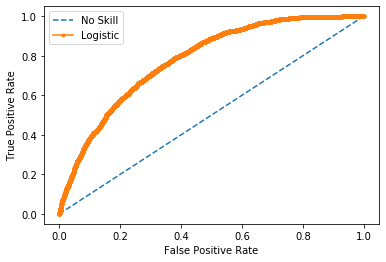

In [63]:
# roc curve and auc

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(pred_ans))]
# predict probabilities
lr_probs = pred_ans

# calculate scores
ns_auc = roc_auc_score(test[target].values, ns_probs)
lr_auc = roc_auc_score(test[target].values, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(test[target].values, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(test[target].values, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

## Resources:

https://deepctr-doc.readthedocs.io/en/latest/Quick-Start.html